##  Car Price Project - Algorithms

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import re
import pprint
import joblib

#pd.set_option('max_colwidth', 2000)
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

#Distributions supporting rvs method
from scipy.stats import randint
from scipy.stats import uniform
from skopt.space import Real

#Feature selection
from eli5.sklearn import PermutationImportance
import eli5

#transformers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

#Model selection
from sklearn.base import clone
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

#Anomaly detection for outliers.
from sklearn.ensemble import IsolationForest

#Models for prediction
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import lightgbm as lgb

#Scoring
from sklearn.metrics import mean_squared_error

C:\Users\Justin\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#Score predictions of fitted model.
def score_algo(model, X, y, prediction):
    print('-----------------------------------------------')
    print(f'##### {type(model).__name__} - Prediction Scores:')
    print('-----------------------------------------------')
    print('RMSE:', round(np.sqrt(mean_squared_error(y, prediction)), 1))
    print(' R^2:', round(r2_score(y, prediction), 4))
    print(' MAE:', round(mean_absolute_error(y, prediction),1))

In [3]:
import psycopg2
from sqlalchemy import create_engine
from sqlalchemy.dialects.postgresql import JSON, JSONB
engine=create_engine("postgresql://postgres@localhost:5432/postgres")

In [4]:
#Read in data tables.  Put quotes around table to make case-sensitive.
vehicle=pd.read_sql('SELECT * from vehicle', engine, index_col='index')
train=pd.read_sql('SELECT * from "trainClean"', engine, index_col='index')
test=pd.read_sql('SELECT * from "testClean"', engine, index_col='index')
vehicle.index.name=None; train.index.name=None; test.index.name=None;

##  Nonlinear Models - LightGBM

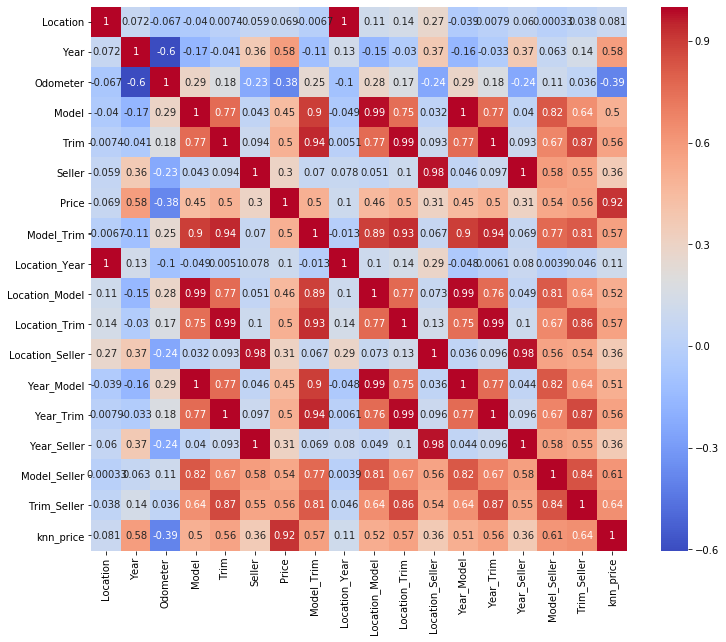

In [5]:
#Show correlation heatmap.  Keeping the collinear features may help prediction, while making the 
#linear regression coefficients less interpretable.
plt.figure(figsize=(12,10))
sns.heatmap(train.corr(), cmap='coolwarm', annot=True)
plt.show()

<a id='section_id1'></a>

### LightGBM with category encoding

In [6]:
#Split out Price
trainX_lenc = train.copy()
trainY_lenc = trainX_lenc.pop('Price')
testX_lenc = test.copy()
testY_lenc = testX_lenc.pop('Price')

In [7]:
trainX_lenc.head(2)

,Location,Year,Odometer,Model,Trim,Seller,Model_Trim,Location_Year,Location_Model,Location_Trim,Location_Seller,Year_Model,Year_Trim,Year_Seller,Model_Seller,Trim_Seller,knn_price
7017,17419.916844,2006.0,226650.0,9697.061538,5176.384615,19554.199579,5.019572e+07,3.494435e+07,1.689220e+08,9.017219e+07,3.406325e+08,1.945231e+07,1.038383e+07,3.922572e+07,1.896183e+08,1.012201e+08,5067.3
8169,17419.916844,2017.0,58529.0,16439.901408,17469.579545,19554.199579,2.871982e+08,3.513597e+07,2.863817e+08,3.043186e+08,3.406325e+08,3.315928e+07,3.523614e+07,3.944082e+07,3.214691e+08,3.416036e+08,24038.7


In [8]:
#CREATE LightGBM model with random search.

clf = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', n_jobs=1, silent=1)

param_grid={"learning_rate": Real(0.01, 1.0, 'log-uniform'),
            "n_estimators": randint(100,200),
            "num_leaves": randint(2, 600), 
            "max_depth": randint(0, 40),
            "min_data_in_leaf": randint(10, 200),  #prevents overfitting
            "max_bin": randint(100,60000),
            "bagging_fraction": Real(0.01, 0.1, 'uniform'),
            "feature_fraction": uniform(0.01, 0.99),
            "subsample_for_bin": randint(100000, 600000),
            "lambda_l2": Real(1e-9, 1000, 'log-uniform'),
            "lambda_l1": Real(1e-9, 1, 'log-uniform'),          
            }

#Instantiate random_search.
lgb_model = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=40, cv=5, n_jobs=-1, refit=True,\
                           scoring='neg_mean_absolute_error', return_train_score=False,random_state=42)

#Tune model with CV. Model will automatically refit on full train with best parameters.
lgb_model.fit(trainX_lenc, trainY_lenc)

#Tuned model best score.
best_score = lgb_model.best_score_
best_score_std = lgb_model.cv_results_['std_test_score'][lgb_model.best_index_]
best_hyperparams = lgb_model.best_params_
print(f'## Grid iters checked: {len(lgb_model.cv_results_["params"])}')
print(f'## best CV score: {best_score:.4f} +- {best_score_std:.4f}\n')
print('## Best parameters:')
pprint.pprint(best_hyperparams)

## Grid iters checked: 40
## best CV score: -2681.5300 +- 89.9300

## Best parameters:
{'bagging_fraction': array([0.06609683]),
 'feature_fraction': 0.3375890446041227,
 'lambda_l1': array([3.73271776e-09]),
 'lambda_l2': array([5.39247153e-06]),
 'learning_rate': array([0.04470609]),
 'max_bin': 30918,
 'max_depth': 39,
 'min_data_in_leaf': 44,
 'n_estimators': 164,
 'num_leaves': 463,
 'subsample_for_bin': 258338}


In [9]:
# #SAVE model
# joblib.dump(lgb_model, 'lgb_model.joblib', compress=0)

# #LOAD model
# lgb_model = joblib.load('lgb_model.joblib')

In [10]:
#PREDICT model.
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
y_test_pred = lgb_model.predict(testX_lenc)
score_algo(lgb_model, testX_lenc, testY_lenc, y_test_pred)

-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------------------
RMSE: 3926.4
 R^2: 0.8854
 MAE: 2460.6


In [11]:
trainX_lenc.head(2)

,Location,Year,Odometer,Model,Trim,Seller,Model_Trim,Location_Year,Location_Model,Location_Trim,Location_Seller,Year_Model,Year_Trim,Year_Seller,Model_Seller,Trim_Seller,knn_price
7017,17419.916844,2006.0,226650.0,9697.061538,5176.384615,19554.199579,5.019572e+07,3.494435e+07,1.689220e+08,9.017219e+07,3.406325e+08,1.945231e+07,1.038383e+07,3.922572e+07,1.896183e+08,1.012201e+08,5067.3
8169,17419.916844,2017.0,58529.0,16439.901408,17469.579545,19554.199579,2.871982e+08,3.513597e+07,2.863817e+08,3.043186e+08,3.406325e+08,3.315928e+07,3.523614e+07,3.944082e+07,3.214691e+08,3.416036e+08,24038.7


In [12]:
#Get feature importances using eli5.
perm = PermutationImportance(lgb_model,n_iter=10).fit(testX_lenc, testY_lenc)
eli5.show_weights(perm, feature_names = testX_lenc.columns.tolist())

Weight,Feature
2538.9938 ± 312.1273,knn_price
1265.9699 ± 202.5095,Year
874.6717 ± 92.7372,Odometer
769.9834 ± 143.5787,Year_Model
620.0350 ± 101.9585,Year_Seller
547.3327 ± 136.6744,Year_Trim
403.3894 ± 104.1925,Model_Trim
154.1359 ± 66.4274,Location_Trim
128.5540 ± 31.5203,Location_Model
91.9492 ± 52.2280,Trim


#### Residuals Plot Function

In [13]:
def plot_residuals(predicted, true):
    '''
    Plots predicted vs error.  Error = true - predicted.  Marks
    three standard deviation error from mean with orange bars.  
    Plots histogram.  Prints error statistics.
    '''
    anomaly_locs = []
    error = true - predicted
    print('error count:', len(error), '| error avg:', round(error.mean(),1), '| high pred percent:', round(100*len(error[error<0])/len(error),1), '| low pred percent:', round(100*len(error[error>=0])/len(error),1), )
    mean = np.mean(error)
    three_std = 3* np.std(error)
    upper_lim = mean + three_std
    lower_lim = mean - three_std
    fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10,30))
    sns.set(font_scale=1.3)
    sns.scatterplot(x=predicted, y=error, ax=ax1, color='black')    
    ax1.set_title('Scatterplot: Predicted vs Error')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Error - True less Predicted')
    ax1.axhline(y=0, color='g', ls='--', alpha=0.8)
    ax1.axhline(y=upper_lim, color='orange', ls='--', alpha=0.8)
    ax1.axhline(y=lower_lim, color='orange', ls='--', alpha=0.8)
    
    for elem in range(0, predicted.shape[0]):  #add iloc for error outside limits. 's=' is the text string.
        x_val = predicted[elem]     #assume predicted is numpy.ndarray
        y_val = error.values[elem]  #assume error is Series
        label_str = str(true.iloc[elem:elem+1].index[0])  #loc
        if (y_val > upper_lim or y_val < lower_lim):
            anomaly_locs.append(true.iloc[elem:elem+1].index[0])
            if (elem % 2) == 0:  #even elements
                ax1.text(x=x_val+500, y=y_val-400, s=label_str, horizontalalignment = 'left', size=14, color='r')
            else:                #odd elements
                ax1.text(x=x_val-2000, y=y_val-1500, s=label_str, horizontalalignment = 'left', size=14, color='r')
    
    sns.distplot(error, ax=ax2, kde=True)
    ax2.set_title('Histogram: Error - True Less Predicted')
    ax2.set_xlabel('Error')
    ax2.set_ylabel('Frequency')
    ax2.axvline(x=0, color='black', ls='--', alpha=0.8)
    
    sns.regplot(x=predicted, y=true, ax=ax3, color='black', marker='.', ci=None)
    ax3.set_title('Linear Regression Plot: Predicted vs True')
    ax3.set_xlabel('Predicted')
    ax3.set_ylabel('True')
    return anomaly_locs

In [14]:
train.head(2)

,Location,Year,Odometer,Model,Trim,Seller,Price,Model_Trim,Location_Year,Location_Model,Location_Trim,Location_Seller,Year_Model,Year_Trim,Year_Seller,Model_Seller,Trim_Seller,knn_price
7017,17419.916844,2006.0,226650.0,9697.061538,5176.384615,19554.199579,2999.0,5.019572e+07,3.494435e+07,1.689220e+08,9.017219e+07,3.406325e+08,1.945231e+07,1.038383e+07,3.922572e+07,1.896183e+08,1.012201e+08,5067.3
8169,17419.916844,2017.0,58529.0,16439.901408,17469.579545,19554.199579,23991.0,2.871982e+08,3.513597e+07,2.863817e+08,3.043186e+08,3.406325e+08,3.315928e+07,3.523614e+07,3.944082e+07,3.214691e+08,3.416036e+08,24038.7


In [15]:
# pd.set_option('max_colwidth', 200)

# #Review loc
# pd.set_option('max_colwidth', 100)
# for locNum in [716]:
#     iloc = np.where(trainX_lenc.index==locNum)[0][0]
#     display('### modeled train:', trainX_lenc.loc[[locNum]])
#     print('true:', trainY_lenc.loc[locNum])
#     print('predicted:', y_trn_pred[iloc])
#     print('error:', trainY_lenc.loc[locNum] - y_trn_pred[iloc])
#     display('### original:', vehicle.loc[[locNum]])
#     display(vehicle.loc[locNum,'Body'])
#     print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')

error count: 3164 | error avg: -0.0 | high pred percent: 50.7 | low pred percent: 49.3


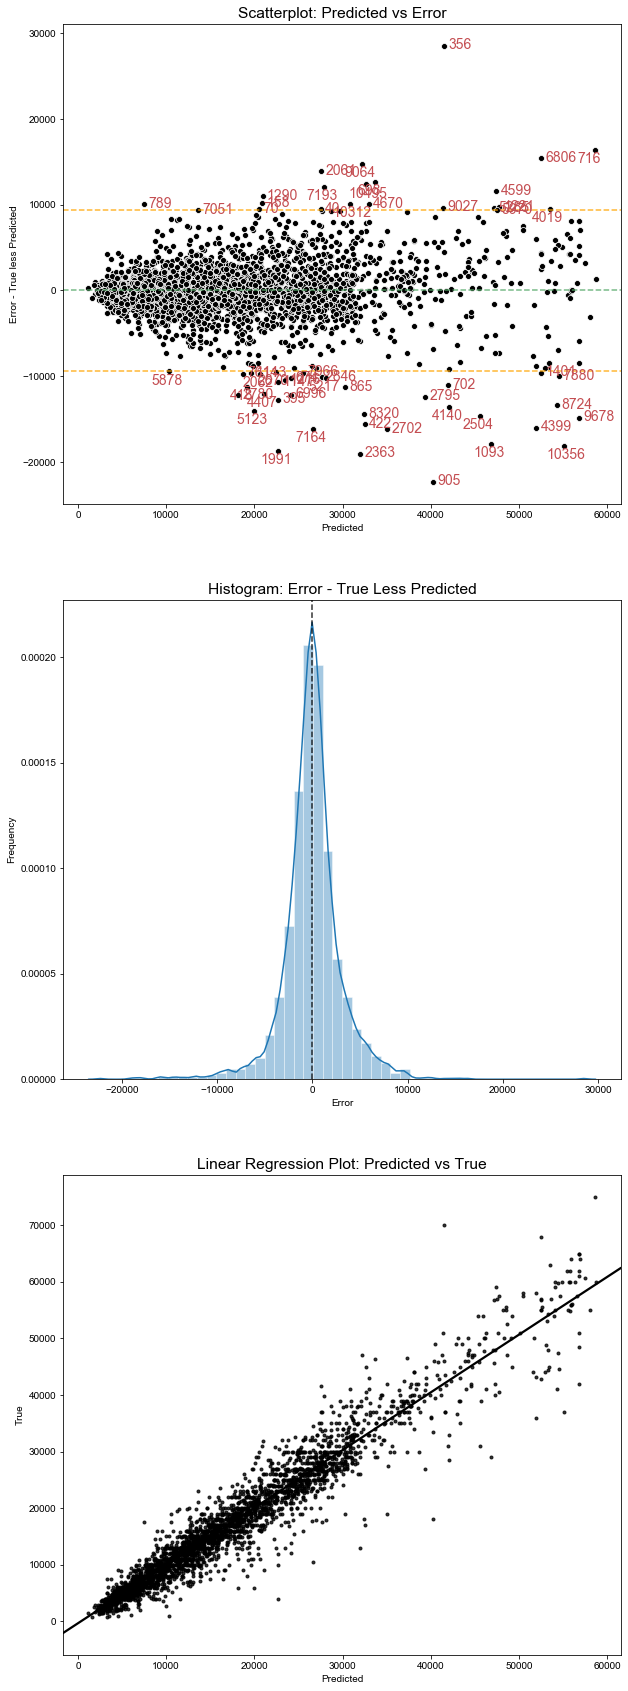

In [16]:
#LightGBM - Plot train 3 sigma anomalies.
y_trn_pred = lgb_model.predict(trainX_lenc)
anomal = plot_residuals(predicted=y_trn_pred, true=trainY_lenc)

error count: 352 | error avg: 187.9 | high pred percent: 46.6 | low pred percent: 53.4


[7189, 6091, 3203, 969, 182, 9593, 3228, 9022, 970, 9256, 8804, 5]

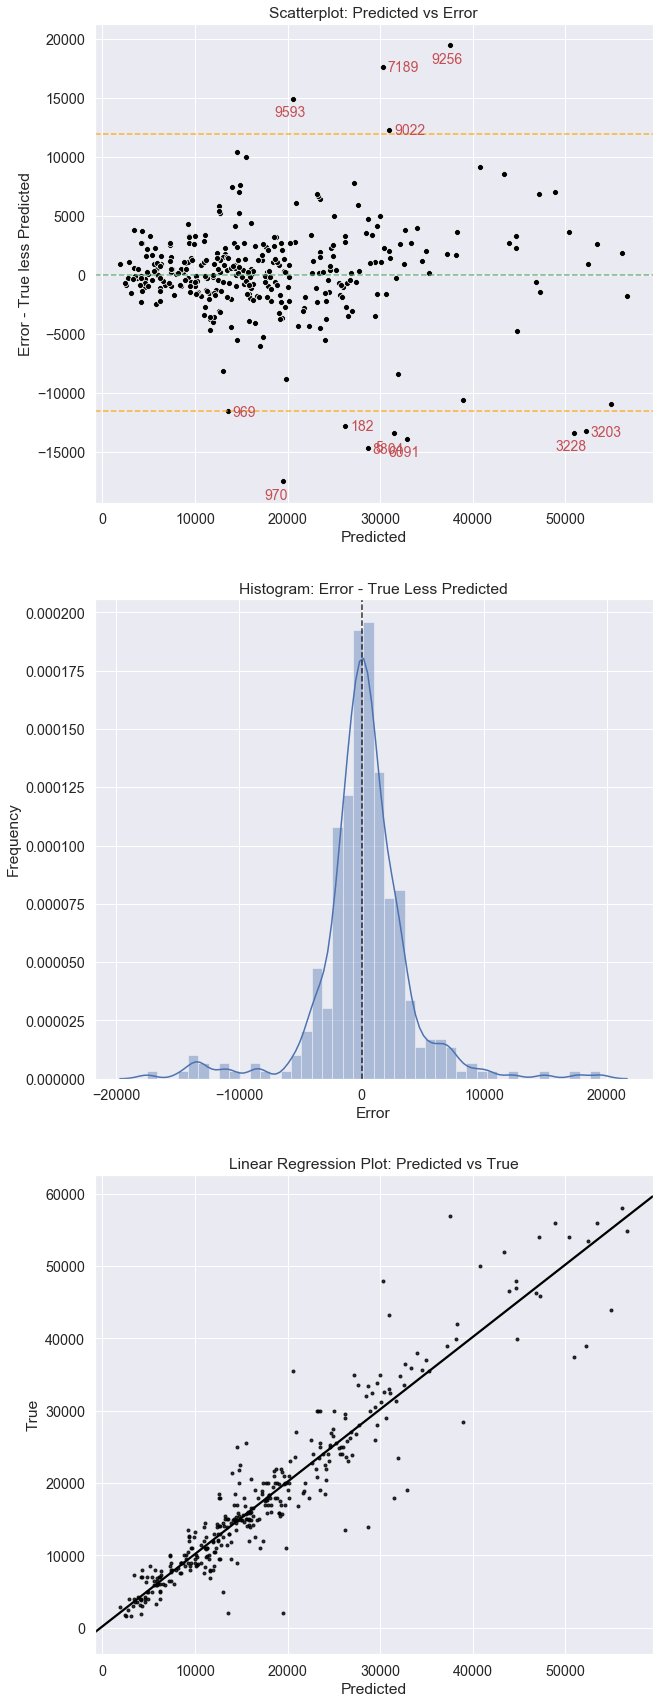

In [17]:
#LightGBM - Plot test residuals
plot_residuals(predicted=y_test_pred, true=testY_lenc)

## Linear Model data

In [18]:
train=pd.read_sql('SELECT * from "trainClean"', engine, index_col='index')
test=pd.read_sql('SELECT * from "testClean"', engine, index_col='index')
train.index.name=None; test.index.name=None; 
train.shape

(3164, 18)

In [19]:
train.head(1)

,Location,Year,Odometer,Model,Trim,Seller,Price,Model_Trim,Location_Year,Location_Model,Location_Trim,Location_Seller,Year_Model,Year_Trim,Year_Seller,Model_Seller,Trim_Seller,knn_price
7017,17419.916844,2006.0,226650.0,9697.061538,5176.384615,19554.199579,2999.0,5.019572e+07,3.494435e+07,1.689220e+08,9.017219e+07,3.406325e+08,1.945231e+07,1.038383e+07,3.922572e+07,1.896183e+08,1.012201e+08,5067.3


In [20]:
#Split out Price
trainX = train.copy()
trainY =trainX.pop('Price')
testX = test.copy()
testY = testX.pop('Price')

### One-Hot Encode

In [21]:
def one_hot_encode(train_df, test_df, cat_cols):
    '''
    One-Hot Encode train category columns.  Apply identical encoding to test.
    Unknown category for test handled by returning all zeroes column.  Function
    keeps original dataframe indices intact.
    '''
    from sklearn.preprocessing import OneHotEncoder
    ohe = OneHotEncoder(sparse=False, drop=None, handle_unknown='ignore')  #drop None or 'first'
    #ohe = OneHotEncoder(sparse=False, drop='first', handle_unknown='error')  #drop None or 'first'
    #fit_transform train cat_cols.
    ohe_train_df=pd.DataFrame(ohe.fit_transform(train_df[cat_cols]))
    ohe_train_df.index=train_df.index
    ohe_train_df.columns=ohe.get_feature_names(cat_cols)
    #Transform test.  Categories exclusive to train get zeros in test.  Categories exclusive to test are omitted.
    ohe_test_df=pd.DataFrame(ohe.transform(test_df[cat_cols]))
    ohe_test_df.index=test_df.index
    ohe_test_df.columns=ohe.get_feature_names(cat_cols)
    return ohe_train_df, ohe_test_df

In [22]:
# #Get One-Hot columns for the specified categ_columns.
# categ_cols= trainX.select_dtypes('object').columns.values
# ohe_train_df, ohe_test_df = one_hot_encode(train_df=trainX, test_df=testX, cat_cols=categ_cols)

# #Drop original category columns.  Concatenate the One-Hot columns.
# trainX = trainX.drop(columns=categ_cols, axis='columns', errors='ignore')
# testX = testX.drop(columns=categ_cols, axis='columns', errors='ignore')

# trainX = pd.concat([trainX, ohe_train_df], axis='columns')
# testX = pd.concat([testX, ohe_test_df], axis='columns')
# display('trainX:', trainX.head(2))
# display('testX:', testX.head(2))

## `Tune Linear Models with Cross Validation`

In [23]:
# #Drop knn_price
# trainX.drop(columns=['knn_price'], inplace=True, errors='ignore')
# testX.drop(columns=['knn_price'], inplace=True, errors='ignore')

# #From residuals plot, drop two worst outliers in test (one high, one low).
# testX.drop(index=[356,1991,7189,9256,9677,8156,674,2496], inplace=True, errors='ignore')
# testY.drop(index=[356,1991,7189,9256,9677,8156,674,2496], inplace=True, errors='ignore')

In [24]:
def train_and_valid(what_model, num_folds, X, y):
    fold_rmse=[]
    kf=KFold(n_splits=num_folds, shuffle=True, random_state=30)    
        
    for train_index, valid_index in kf.split(X):
        #Clone is a model copy not yet fit on the data.  Initial conditions impact certain model results, like SGD.
        clone_model = clone(what_model)                                  
        trn_X, valid_X = X.iloc[train_index, :], X.iloc[valid_index, :]  #df has columns
        trn_y, valid_y = y.iloc[train_index], y.iloc[valid_index]        #series no columns
        clone_model.fit(trn_X, trn_y)
        valid_pred=clone_model.predict(valid_X)
        fold_rmse.append(round(np.sqrt(mean_squared_error(valid_y, valid_pred)), 2))
        
    print(f'***Tune {type(what_model).__name__}***\n## Fold RMSE:', fold_rmse)
    print('## Avg RMSE:', round(np.mean(fold_rmse),1),'+-', round(np.std(fold_rmse),1))
    print('## Clone R^2:', round(clone_model.score(X,y),3))
    return clone_model

In [25]:
#Tune LR with CV
lr=LinearRegression(fit_intercept=True)
lr_clone=train_and_valid(what_model=lr, num_folds=10, X=trainX, y=trainY)

***Tune LinearRegression***
## Fold RMSE: [4222.02, 4412.14, 4063.5, 4324.63, 3612.45, 4324.04, 4478.49, 4435.27, 4660.06, 4340.26]
## Avg RMSE: 4287.3 +- 269.9
## Clone R^2: 0.86


In [26]:
#Get LinearRegression feature importances.  Note: collinearity distorts feature importances.
perm = PermutationImportance(lr_clone,n_iter=4).fit(trainX, trainY)
eli5.show_weights(perm, feature_names = trainX.columns.tolist())

Weight,Feature
987.5261 ± 18.6110,Year_Trim
939.9247 ± 25.2235,Trim
149.8429 ± 2.1586,Year_Model
143.1080 ± 3.1627,Model
1.3862 ± 0.0435,knn_price
1.0662 ± 0.0287,Year_Seller
0.9840 ± 0.0277,Seller
0.8571 ± 0.0295,Location_Trim
0.2165 ± 0.0103,Location_Model
0.0073 ± 0.0023,Location_Seller


## `Linear Model Predictions - Fit on 100% of train`

In [27]:
linregr=LinearRegression(fit_intercept=True)  #no scaling required for closed-form solution
linregr.fit(trainX, trainY)
y_pred_linregr=linregr.predict(testX)
score_algo(linregr, testX, testY, y_pred_linregr)

-----------------------------------------------
##### LinearRegression - Prediction Scores:
-----------------------------------------------
RMSE: 4687.0
 R^2: 0.8366
 MAE: 3050.2


error count: 352 | error avg: 169.2 | high pred percent: 50.0 | low pred percent: 50.0


[9378, 7189, 6091, 3203, 9593, 9022, 970, 4122, 9256, 8804, 5, 9851]

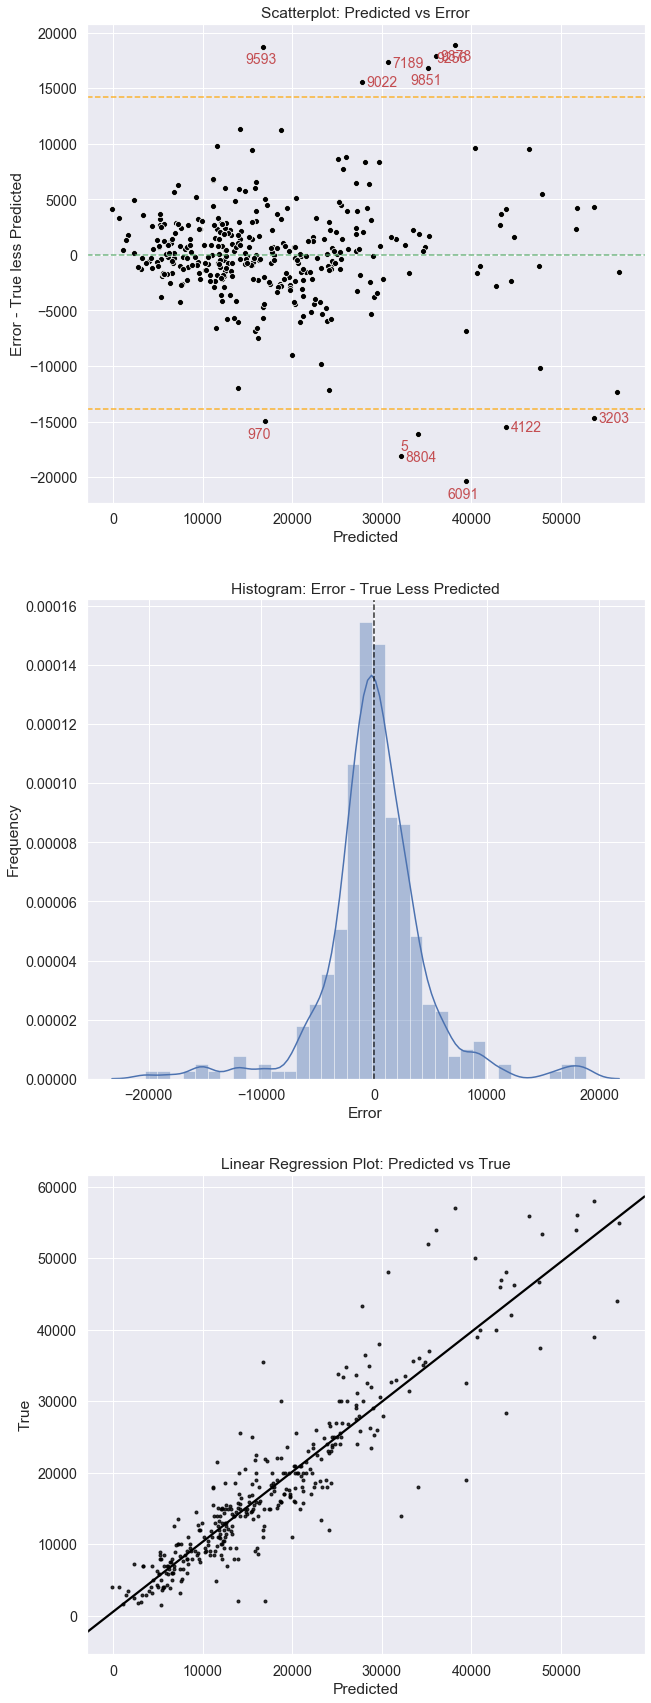

In [28]:
#Get test residuals
plot_residuals(predicted=y_pred_linregr, true=testY)

In [29]:
# def get_anomalies(trainX, testX):
#     '''Return anomalies from trainX and testX.'''
#     #Instantiate, fit, and predict with Isolation Forest.
#     isof = IsolationForest(n_estimators = 200, max_samples ='auto', max_features=1.0, contamination=0.1,
#                            behaviour='deprecated', n_jobs=-1, random_state=33)
#     trn_preds = isof.fit_predict(trainX)
#     tst_preds = isof.predict(testX)

#     #Save outliers (-1) to indexed series.
#     trn_preds = pd.Series(data=trn_preds, index=trainX.index, name='OutlierTrn')
#     trn_anom = trn_preds[trn_preds == -1]
#     tst_preds = pd.Series(data=tst_preds, index=testX.index, name='OutlierTst')
#     tst_anom = tst_preds[tst_preds == -1]

#     #Print anomalies found.
#     trn_drops = trn_anom.index
#     tst_drops=tst_anom.index
#     print(f'## {len(trn_drops)} trainX anomalies flagged by Isolation Forest:', trn_drops)       
#     print(f'\n## {len(tst_drops)} testX anomalies flagged by Isolation Forest:', tst_drops)
    
#     return trn_drops, tst_drops

# #GEt trainX and testX anomalies.  Assumes same contamination level.
# trainX_anom, testX_anom  = get_anomalies(trainX=trainX_lenc, testX=testX_lenc)

# #Drop train anomalies but not test anomalies.
# trainX_lenc.drop(index = trainX_anom, inplace=True, errors = 'ignore')
# trainY_lenc.drop(index = trainX_anom, inplace=True, errors = 'ignore')

# testX_lenc.drop(index = testX_anom, inplace=True, errors = 'ignore')
# testY_lenc.drop(index = testX_anom, inplace=True, errors = 'ignore')